In [13]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy import signal
import csv
from scipy import fft
from scipy.fftpack import fft, fftfreq, ifft
from scipy import interpolate

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,5)

In [24]:
def read_antfile():
	antdata = np.loadtxt("pueo_antpos.txt", skiprows=1, delimiter=',')

	tantdata = np.transpose(antdata)

	antarr = np.recarray(len(tantdata[0]), dtype=[('ant_id', int), ('x', float), ('y', float), ('z', float)])

	antarr['ant_id'] = tantdata[0]
	antarr['x'] = tantdata[1]
	antarr['y'] = tantdata[2]
	antarr['z'] = tantdata[3]

	return antarr

def norm_to_ang(norm):
    x = norm[0]
    y = norm[1]
    z = norm[2]
    
    phi = np.arctan(y/x)
    th = np.arccos(z/np.sqrt(x**2+y**2+z**2))
    return np.degrees(phi), np.degrees(th)

def ang_to_norm(th, phi):
    x = np.cos(np.radians(phi))*np.cos(np.radians(th))
    y = np.sin(np.radians(phi))*np.cos(np.radians(th))
    z = np.sin(np.radians(th))
    
    norm = 1./np.sqrt(x**2+y**2+z**2)
    return -1.*norm*np.array([x,y,z])

In [15]:
antdata = read_antfile()
print(antdata.dtype.names)
print(antdata)
which_ids = [0, 1, 24, 25, 48,49, 72, 73]
ant_sector = antdata[which_ids]

('ant_id', 'x', 'y', 'z')
[(  0,  8.0520e-01, -0.4648, -1.9431) (  1,  1.0058e+00, -0.2718, -1.3106)
 (  2,  9.7150e-01,  0.    , -1.9431) (  3,  1.0058e+00,  0.2718, -1.3106)
 (  4,  8.0510e-01,  0.4649, -1.9431) (  5,  7.3830e-01,  0.7352, -1.3106)
 (  6,  4.8580e-01,  0.8414, -1.9431) (  7,  2.6760e-01,  1.007 , -1.3106)
 (  8, -0.0000e+00,  0.9297, -1.9431) (  9, -2.6760e-01,  1.007 , -1.3106)
 ( 10, -4.8580e-01,  0.8414, -1.9431) ( 11, -7.3830e-01,  0.7352, -1.3106)
 ( 12, -8.0520e-01,  0.4648, -1.9431) ( 13, -1.0058e+00,  0.2718, -1.3106)
 ( 14, -9.7150e-01,  0.    , -1.9431) ( 15, -1.0058e+00, -0.2718, -1.3106)
 ( 16, -8.0510e-01, -0.4649, -1.9431) ( 17, -7.3830e-01, -0.7352, -1.3106)
 ( 18, -4.8580e-01, -0.8414, -1.9431) ( 19, -2.6760e-01, -1.007 , -1.3106)
 ( 20,  0.0000e+00, -0.9297, -1.9431) ( 21,  2.6760e-01, -1.007 , -1.3106)
 ( 22,  4.8580e-01, -0.8414, -1.9431) ( 23,  7.3830e-01, -0.7352, -1.3106)
 ( 24,  1.9380e+00, -1.1176, -4.9784) ( 25,  2.1590e+00, -0.5842, -4.9784)

6.691295749674931e-10
5e-08
10.0 15.121998571306579 -1
10.0 29.995600328493378 -3
10.0 15.140983835076907 10
10.0 29.97105937632659 8
10.0 15.140983835076907 10
10.0 29.97105937632659 8
10.0 15.140983835076907 10
10.0 29.97105937632659 8
1733.2356072151208
245.00410071342185


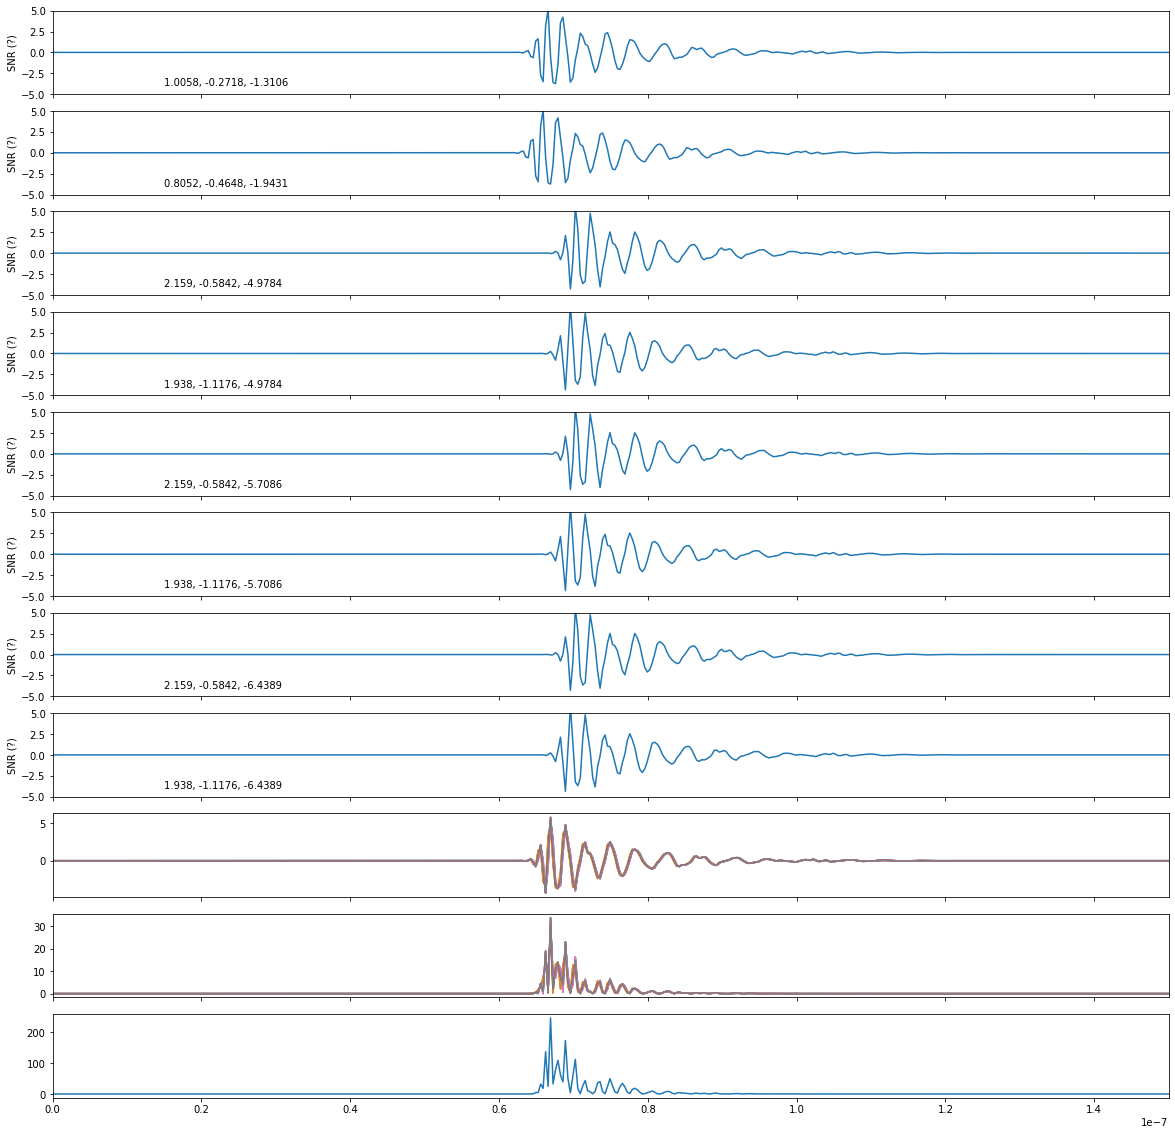

In [23]:
from operator import itemgetter
from scipy.ndimage.interpolation import shift

c = 299792458

normal = np.array([1., 0., 0.])
point = np.array([0., 0., 0.])

temphits = []
for ant in ant_sector:
    d = [ant['ant_id'], ant['x'], ant['y'], ant['z'],np.degrees(np.arctan(ant['y']/ant['x'])), -10.] 
    antn = d[0]
    antpos = d[1:]
    d = dist_to_plane(normal, point, antpos)
    hittime = d/c
    hitangle =  calc_hitangle(normal, antpos)
    hitth = hitangle[1]
    hitphi = hitangle[0]
    #print(antpos, d, hittime)
    temphits.append([antn, antpos[0], antpos[1], antpos[2], hittime, hitphi, hitth])

temphits = np.array(temphits)
temphits = temphits[temphits[:,4].argsort()]
hittimes = [t[4] for t in temphits]
firsthit = hittimes[0]
tshift = firsthit# - 10e-9
newhittimes = hittimes-tshift

adjhits = [[temphits[i][0], temphits[i][1], temphits[i][2], temphits[i][3], newhittimes[i], temphits[i][5], temphits[i][6]] for i in range(0,len(temphits))]
adjhits = np.array(adjhits)

adjhits = adjhits[adjhits[:, 3].argsort()][::-1]

hittimes = [t[4] for t in adjhits]
refhit = adjhits[0][4]
print(refhit)
tshift = refhit-0.5e-7
newhittimes = hittimes-tshift
adjhits = [[adjhits[i][0], adjhits[i][1], adjhits[i][2], adjhits[i][3], newhittimes[i], adjhits[i][5], adjhits[i][6]] for i in range(0,len(adjhits))]

print(adjhits[0][4])
startphase = np.random.random_sample()

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

fig, ax = plt.subplots(11,1,sharex='col', sharey='row')

ant_powers = []
m=0
for testhit in adjhits:
    hitn = testhit[0]
    hitx = testhit[1]
    hity = testhit[2]
    hitz = testhit[3]
    testtime = testhit[4]
    hitphi = testhit[5]
    hitth = testhit[6]

    this_ir3 = impulse(testtime, startphase)
    #print(hitth, hitphi)
        
    t = np.arange(total_len)*(0.333e-9)
    sampleshift = int(testtime//0.333e-9)-int(0.5e-7//0.33e-9)
    print(hitth, hitphi, sampleshift)

    sig_shifted = np.roll(this_ir3, -1*sampleshift)

    
    if 0<=m<9:
        j = 0
        i = m
    if 9<=m<18:
        j = 1
        i = m-9
    ax[i].plot(t, this_ir3[0:total_len])
    ax[i].set_ylim(-5,5)
    ax[i].set_xlim(0.,1.5e-7)
    ax[i].annotate('%s, %s, %s'%(hitx, hity, hitz), xy=(0.1,0.1), xycoords='axes fraction')
    m+=1
    
    if j == 0:
        ax[i].set_ylabel('SNR (?)')
    if i == 9:
        ax[i].set_xlabel('Time [s]')
        
    ax[8].plot(t, sig_shifted[0:total_len])
    ax[9].plot(t, np.absolute(sig_shifted[0:total_len])**2)
    
    ant_power = np.absolute(sig_shifted[0:total_len]**2)
    ant_powers.append(ant_power)
    
plt.rcParams["figure.figsize"] = (9,5)

ant_powers = np.array(ant_powers)
total_power = np.sum(ant_powers, axis=0)
print(np.sum(total_power))
print(np.max(total_power))
ax[10].plot(t, total_power)